# Text‑based Cyber Threat Detection

#### Authors: Kelvin Kipkorir,Lucy Mutua,Charles Mutembei,Sharon Aoko, Victor

[image]

# Overview

# Problem Statement

# Objectives

The goal of this project is to build a machine learning model that can classify text data as either a cyber threat or not. We'll leverage NLP techniques and classification algorithms to detect potential threats from text-based data.


# Data Understanding

In [1]:
#import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Looking through the dataset

In [2]:
df = pd.read_csv('cyber-threat-intelligence_all.csv')
df

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,1.0,This post is also available in: 日本語 (Japa...,"[{'id': 45800, 'label': 'malware', 'start_offs...",[],[],45800.0,malware,288.0,300.0
1,1,2.0,The attack vector is very basic and repeats it...,"[{'id': 48941, 'label': 'attack-pattern', 'sta...",[],[],48941.0,attack-pattern,69.0,115.0
2,2,3.0,Once executed by the user the first stage malw...,[],[],[],NaN,NaN,NaN,NaN
3,3,4.0,The first known campaign was launched by Crim...,"[{'id': 45806, 'label': 'TIME', 'start_offset'...",[],[],45806.0,TIME,55.0,68.0
4,4,5.0,The first stage downloaded the ransomware from...,[],[],[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19935,5279,NaN,"Cyclops Blink, an advanced modular botnet that...",NaN,NaN,NaN,NaN,malware,NaN,NaN
19936,1543,NaN,Sofacy Group has been associated with many at...,NaN,NaN,NaN,NaN,location,NaN,NaN
19937,13595,NaN,The plugin has been designed to drop multiple ...,NaN,NaN,NaN,NaN,Infrastucture,NaN,NaN
19938,2368,NaN,We have uncovered a cyberespionage campaign be...,NaN,NaN,NaN,NaN,threat-actor,NaN,NaN


The dataset has 19940 rows and 10 columns.We can see that the dataset has a lot of missing values. We can dig further looking at missing elements in each individual rows

In [3]:
# looking at the stats for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    19940 non-null  int64  
 1   index         19464 non-null  float64
 2   text          19940 non-null  object 
 3   entities      19464 non-null  object 
 4   relations     19464 non-null  object 
 5   Comments      19464 non-null  object 
 6   id            9462 non-null   float64
 7   label         9938 non-null   object 
 8   start_offset  9462 non-null   float64
 9   end_offset    9462 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.5+ MB


In [4]:
#looking at the available labels
df['label'].value_counts()

malware           1911
location          1405
SOFTWARE          1229
attack-pattern    1206
identity          1165
threat-actor       890
TIME               475
tools              391
FILEPATH           313
vulnerability      245
SHA2               160
campaign           128
URL                127
IPV4                61
SHA1                60
DOMAIN              50
Infrastucture       43
EMAIL               24
REGISTRYKEY         19
MD5                 16
hash                14
url                  6
Name: label, dtype: int64

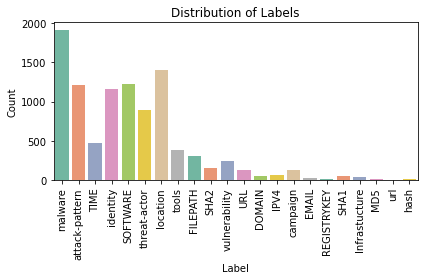

In [5]:
#visualizing using a count plot
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of Labels')
plt.xlabel('Label') 
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()


### For our analysis the `text ` and `label` columns are the ones we are going to use which means that we will drop all other columns

In [6]:
data = df['text']
target = df['label']

In [7]:
df['entities'].head()

0    [{'id': 45800, 'label': 'malware', 'start_offs...
1    [{'id': 48941, 'label': 'attack-pattern', 'sta...
2                                                   []
3    [{'id': 45806, 'label': 'TIME', 'start_offset'...
4                                                   []
Name: entities, dtype: object

We noticed many missing values in the `label` column, so we extracted the first entity label from the `entities` JSON column to recover useful annotations. The new labels are stored in a separate column called `entity_label` for further analysis.


In [8]:
import ast #useful in extracting components safely

#  function to extract the 'label' from the 'entities' JSON string
def extract_entity_label(entities):
    try:
        entity_list = ast.literal_eval(entities)  
        if isinstance(entity_list, list) and len(entity_list) > 0:
            return entity_list[0].get('label')  
    except (ValueError, SyntaxError):
        return None
    return None

#create a new column
df['entity_label'] = df['entities'].apply(extract_entity_label)

# Check distribution of extracted labels
print(df['entity_label'].value_counts())

malware           1770
location          1382
SOFTWARE          1204
attack-pattern    1162
identity          1128
threat-actor       822
TIME               458
tools              372
FILEPATH           298
vulnerability      210
SHA2               160
URL                124
campaign           108
SHA1                60
IPV4                60
DOMAIN              50
Infrastucture       36
EMAIL               24
REGISTRYKEY         18
MD5                 16
Name: entity_label, dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    19940 non-null  int64  
 1   index         19464 non-null  float64
 2   text          19940 non-null  object 
 3   entities      19464 non-null  object 
 4   relations     19464 non-null  object 
 5   Comments      19464 non-null  object 
 6   id            9462 non-null   float64
 7   label         9938 non-null   object 
 8   start_offset  9462 non-null   float64
 9   end_offset    9462 non-null   float64
 10  entity_label  9462 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 1.7+ MB


## Preprocessing

In [10]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-alphabetic characters
    return text

df['clean_text'] = df['text'].astype(str).apply(clean_text)


In [12]:
df['clean_text']

0        this post is also available in       japanese ...
1        the attack vector is very basic and repeats it...
2        once executed by the user the first stage malw...
3         the first known campaign was launched by crim...
4        the first stage downloaded the ransomware from...
                               ...                        
19935    cyclops blink an advanced modular botnet that ...
19936     sofacy group has been associated with many at...
19937    the plugin has been designed to drop multiple ...
19938    we have uncovered a cyberespionage campaign be...
19939    based on the analysis of samples that were las...
Name: clean_text, Length: 19940, dtype: object